In [0]:
import json
import pandas as pd
import numpy as np
import time
import math 
import string, re
import matplotlib.pyplot as plt
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
f = open('/content/drive/My Drive/HW3/labeled_small.json','r')
data = json.load(f)

In [0]:
beer = pd.DataFrame.from_dict(data)

In [5]:
type(beer)

pandas.core.frame.DataFrame

In [6]:
beer

,style,palate,review_id,brewer,taste,overall,review,appearance,aroma,beer_name,beer_id
0,17,3.0,0,3084,6.0,13.0,"On tap at the Springfield, PA location. Poured...",4.0,6.0,John Harvards Simcoe IPA,45842
1,17,4.0,1,3084,7.0,13.0,On tap at the John Harvards in Springfield PA....,4.0,6.0,John Harvards Simcoe IPA,45842
2,33,3.0,2,3084,6.0,14.0,"UPDATED: FEB 19, 2003 Springfield, PA. I've ne...",4.0,5.0,John Harvards Cristal Pilsner,95213
3,33,2.0,3,3084,4.0,8.0,On tap the Springfield PA location billed as t...,2.0,4.0,John Harvards Fancy Lawnmower Beer,65957
4,58,4.0,5,3084,7.0,16.0,"Springfield, PA location... Poured an opaque b...",5.0,8.0,John Harvards Vanilla Black Velvet Stout,41336
...,...,...,...,...,...,...,...,...,...,...,...
99995,69,2.0,117585,4115,6.0,11.0,Bottle. Pale amber color with a nice white hea...,3.0,8.0,Mission Street Pale Ale,68983
99996,69,2.0,117586,4115,6.0,12.0,12 oz single bought at Trader Joes.\tPretty ne...,2.0,8.0,Mission Street Pale Ale,68983
99997,69,3.0,117587,4115,7.0,14.0,Golden-copper with foamy head. Strong floral-...,4.0,8.0,Mission Street Pale Ale,68983
99998,69,3.0,117588,4115,6.0,12.0,"Nice, simple pale ale (title pale ale but had ...",3.0,6.0,Mission Street Pale Ale,68983


In [0]:
with open('/content/drive/My Drive/HW3/vocab_30.json', 'r') as f:
    vocab = json.load(f)

In [8]:
len(vocab)

41346

In [0]:
# Part 1: Data Inspection 

In [10]:
beer.describe()

,style,palate,review_id,brewer,taste,overall,appearance,aroma,beer_id
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.00000
mean,36.464290,3.277750,58770.913290,3992.036020,6.53204,13.396420,3.459630,6.447190,55650.48179
std,22.538597,0.773156,33904.099683,2477.817908,1.43963,2.949437,0.756529,1.439254,33327.57236
min,0.000000,1.000000,0.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.00000
25%,16.000000,3.000000,29481.750000,1786.000000,6.00000,12.000000,3.000000,6.000000,26244.00000
50%,37.000000,3.000000,58777.500000,4812.500000,7.00000,14.000000,3.000000,7.000000,56100.00000
75%,58.000000,4.000000,88103.500000,6329.000000,7.00000,15.000000,4.000000,7.000000,86041.00000
max,73.000000,5.000000,117589.000000,7523.000000,10.00000,20.000000,5.000000,10.000000,110283.00000


In [0]:
# Mean: 13.396 
# Median: 14.000
# Standard Deviation: 2.949 

In [0]:
# Now, do people have a similar taste? In order to answer this question,
# We can assume that if people do, they will leave similar ratings for 
# the same kind of beers. Then, the standard deviation of ratings for 
# a selected beer should be quite small compared to the overall ratings
# for all kinds of beers 

In [0]:
# Let's try three examples 

In [0]:
beer1 = beer[beer["beer_name"] == "Mission Street Pale Ale"]
beer2 = beer[beer["beer_name"] == "Burggraf Maibock"]
beer3 = beer[beer["beer_name"] == "Barley Island Barrel-Aged Count Hopula"]

In [15]:
beer1["overall"].std()

2.1420781684525454

In [16]:
beer2["overall"].std()

1.789114825239473

In [17]:
beer3["overall"].std()

0.8997354108424372

In [0]:
# The standard deviation of the overall rating of all beers was 2.949. 
# We can see that the overall ratings of the above three beers have standard
# deviations lower than this threshold, but some are much lower than others. 
# We can argue that people could have similar tastes for only some types of beer 

In [0]:
# Part 2 

In [0]:
# (a) Generating Features 

In [0]:
# Splitting data into training, validation, and testing 

In [0]:
# But First, create a function that gives binary labels 

In [0]:
label = np.array(beer["overall"] >= 14).astype(int)

In [0]:
train_data, test_data, train_label, test_label = train_test_split(beer, label, test_size = 0.3, random_state =2)
val_data, test_data, val_label, test_label = train_test_split(test_data, test_label, test_size = 0.5, random_state =2)

In [0]:
# function that normalize the text 

In [0]:
vocab_index = {}
vocab_lst = list(vocab.keys())
for i, vocab in enumerate(vocab_lst): 
    vocab_index[vocab] = i

In [0]:
def normalize_txt(data):
    r = re.compile("[" + re.escape(string.punctuation) + "]")
    normal = [] 
    for i, row in data.iterrows():
        words = r.sub('', row['review'])
        split = words.split(' ')
        lst = []
        for s in split:
            if s in vocab_index: 
                lst.append(s)
        normal.append(lst)
    return normal

In [0]:
# function that creates sparse matrix 

In [0]:
def create_sparse(document, vocab_index_):
    indptr = [0]
    indices = []
    data = []
    for doc in document: 
        terms = set(doc) 
        for term in terms:
            index = vocab_index_[term]
            indices.append(index)
            data.append(1)
        indptr.append(len(indices))
    sparse = csr_matrix((data, indices, indptr), dtype = bool).astype(int)
    return sparse

In [30]:
time_start = time.time()
norm_doc = normalize_txt(train_data)
print(time.time() - time_start)

9.474142074584961


In [31]:
time_start = time.time()
sparse = create_sparse(norm_doc, vocab_index)
print(time.time() - time_start)

1.0818650722503662


In [0]:
# It takes about 1.117 seconds to go over the entire training data set, which is 
# 70,000 documents long  

In [0]:
# part (b): Logistic Regression

In [0]:
sparse_test = create_sparse(normalize_txt(test_data), vocab_index)

In [0]:
sparse_val = create_sparse(normalize_txt(val_data), vocab_index)

In [36]:
start = time.time()
lg = LogisticRegression(penalty = "l2", C = 1/10, solver = 'newton-cg')
lg.fit(sparse, train_label)
print(time.time() - start)

3.860454559326172


In [37]:
score = accuracy_score(val_label, lg.predict(sparse_val))
score

0.7605333333333333

In [0]:
# selecting the optimal lambda_ by tring different values on the validation set 

In [39]:
lambda_set1 = [1, 5, 10, 20, 30, 40, 50, 70, 100, 300, 500, 1000]
accuracy1 = []
for lam in lambda_set1:
    print("lambda: {} | Penalty C: {}".format(lam, 1/lam))
    lg = LogisticRegression(penalty = "l2", C = 1/lam, solver = 'newton-cg')
    start = time.time()
    lg.fit(sparse, train_label)
    score = accuracy_score(val_label, lg.predict(sparse_val))
    accuracy1.append(score)
    print("operation time: %s" %(time.time() - start))
    print("accuracy: %s" %(score))

lambda: 1 | Penalty C: 1.0
operation time: 7.5562450885772705
accuracy: 0.7518
lambda: 5 | Penalty C: 0.2
operation time: 4.4831624031066895
accuracy: 0.7587333333333334
lambda: 10 | Penalty C: 0.1
operation time: 3.943840503692627
accuracy: 0.7605333333333333
lambda: 20 | Penalty C: 0.05
operation time: 3.605893135070801
accuracy: 0.7625333333333333
lambda: 30 | Penalty C: 0.03333333333333333
operation time: 3.516540288925171
accuracy: 0.7606666666666667
lambda: 40 | Penalty C: 0.025
operation time: 3.1036739349365234
accuracy: 0.7603333333333333
lambda: 50 | Penalty C: 0.02
operation time: 2.9787139892578125
accuracy: 0.7588
lambda: 70 | Penalty C: 0.014285714285714285
operation time: 2.881065607070923
accuracy: 0.7563333333333333
lambda: 100 | Penalty C: 0.01
operation time: 2.623732566833496
accuracy: 0.7542
lambda: 300 | Penalty C: 0.0033333333333333335
operation time: 2.144583225250244
accuracy: 0.744
lambda: 500 | Penalty C: 0.002
operation time: 2.358748435974121
accuracy: 0.73

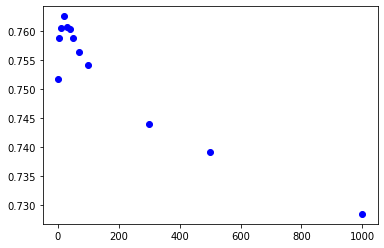

In [40]:
plt.plot(lambda_set1, accuracy1, 'bo')

In [0]:
# The accuracy rate was the highest when lambda = 20.  
# With lambda = 20, it took about 3.5 seconds to run the algorithm in order to 
# attain accuracy rate of 0.7625

In [0]:
# Moving on to the LinearSVC class 

In [43]:
lambda_set2 = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
accuracy2 = []
for lam in lambda_set2:
    print("lambda: {} | penalty C: {} ".format(lam, 1 / lam))
    lsvc = LinearSVC(penalty = 'l2', loss = 'hinge', C = 1/lam)
    start = time.time()
    lsvc.fit(sparse, train_label)
    score = accuracy_score(val_label, lsvc.predict(sparse_val))
    accuracy2.append(score)
    print("operation time: %s " % (time.time() - start))
    print("accuracy: %s"%(score))

lambda: 1 | penalty C: 1.0 


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


operation time: 5.048051595687866 
accuracy: 0.7420666666666667
lambda: 10 | penalty C: 0.1 
operation time: 1.37498140335083 
accuracy: 0.7575333333333333
lambda: 20 | penalty C: 0.05 
operation time: 0.6204280853271484 
accuracy: 0.7577333333333334
lambda: 30 | penalty C: 0.03333333333333333 
operation time: 0.5432126522064209 
accuracy: 0.7586
lambda: 40 | penalty C: 0.025 
operation time: 0.4545018672943115 
accuracy: 0.7587333333333334
lambda: 50 | penalty C: 0.02 
operation time: 0.33524274826049805 
accuracy: 0.759
lambda: 60 | penalty C: 0.016666666666666666 
operation time: 0.3623623847961426 
accuracy: 0.7580666666666667
lambda: 70 | penalty C: 0.014285714285714285 
operation time: 0.28708910942077637 
accuracy: 0.7578666666666667
lambda: 80 | penalty C: 0.0125 
operation time: 0.25193142890930176 
accuracy: 0.7568666666666667
lambda: 90 | penalty C: 0.011111111111111112 
operation time: 0.23581838607788086 
accuracy: 0.7565333333333333
lambda: 100 | penalty C: 0.01 
operatio

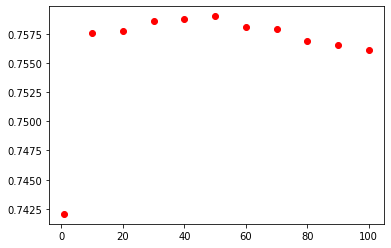

In [44]:
plt.plot(lambda_set2, accuracy2, 'ro')

In [0]:
# Using hinge loss instead of logistic loss, lambda = 50 seems to be close to 
# the optimal lambda value. It provided an accuracy rate of 0.759 with 
# operation time of about 0.26 seconds. We can conclude that under the given 
# circumstances, the logistic Regression model showed slightly higher (very small
# difference) accuracy, but the lsvc model computed the algorithms faster. 

In [0]:
# part (c): Stochastic gradient descent 

In [0]:
def yield_batches(x, y, epochs):
    np.random.shuffle(x)
    for e in range(epochs):
        interval = x.shape[0] // epochs
        yield x[int(e*interval): int((e + 1)*interval)], np.array(y[int(e*interval): int((e + 1)*interval)])[:, np.newaxis]

In [0]:
def compute_h(x, coef):
    return 1 /(1 + np.exp(-np.dot(x, coef)))

In [0]:
def compute_gradient(x, y, coef):
    h = compute_h(x, coef)
    return (h - y) * x 

In [0]:
def compute_error_rate(x, y, coef):
    pred = np.matmul(x, coef)
    y = np.array(y)[:, np.newaxis]
    return np.mean(1/2 * (np.power((pred - y), 2)))

In [0]:
def perform_sgd(x, y, learning_rate, lambda_, epochs, decrease = False, plot = True):
    if type(x) != np.ndarray:
        x = x.toarray()
    x = np.concatenate((np.ones(len(x))[:, np.newaxis], x), axis = 1)
    coef = np.zeros((x.shape[1], 1))
    batches = yield_batches(x, y, epochs)
    er = []
    for i in range(epochs):
        x_b , y_b = next(batches)
        gradient = np.zeros((len(coef), 1))
        error = compute_error_rate(x, y, coef)
        er.append(error)
        for j in range(len(x_b)):
            gradient += (compute_gradient(x_b[j], y_b[j], coef)[:, np.newaxis]) 
        if decrease: 
            coef = coef - learning_rate/(i+1) * (gradient / len(x_b) + lambda_ * coef)
        else: 
            coef = coef - learning_rate * (gradient / len(x_b) + lambda_ * coef)  
        
    if plot:
        plt.plot(er, "g")

    return coef

In [0]:
# Performing Stochastic Gradient Descent without decreasing learning rate

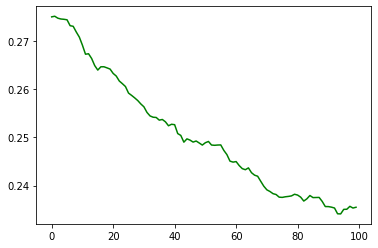

In [53]:
coef = perform_sgd(sparse[:10000], train_label[:10000], 0.01, 0.1, 100, decrease = False, plot = True)

In [0]:
# Performing Stochastic Gradient Descent with decreasing learning rate

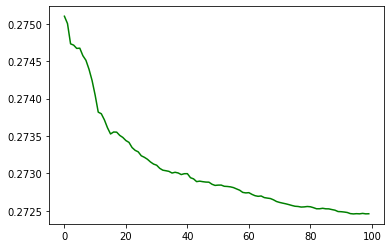

In [55]:
coef = perform_sgd(sparse[:10000], train_label[:10000], 0.01, 0.1, 100, decrease = True, plot = True)

In [0]:
# We can see that the error rate falls and converges as iterations proceed. 
# When we use decreasing learning rate, we can erase most of the noise that 
# causes oscillation and reach convergence much faster   

In [0]:
# compute accuracy of the model by adopting misclassificaiton threshold as 0.5

In [0]:
def compute_mis(coef, x_n, y_n):
    x = np.concatenate((np.ones(len(x_n))[:,np.newaxis], x_n), axis = 1)
    eta = np.matmul(x, coef)
    c = 0
    for i in range(len(y_n)):
        if eta[i] > 0:
            if y_n[i] == 0:
                c +=1
        elif eta[i] < 0 :
            if y_n[i] == 1:
                c += 1
    return c / len(y_n)

In [0]:
# now, let's test with different lambdas and number of iterations 

lambda: 0.0001 | epoch: 10 | error rate: 0.4554
lambda: 0.0001 | epoch: 50 | error rate: 0.4554
lambda: 0.0001 | epoch: 100 | error rate: 0.4554666666666667
lambda: 0.0001 | epoch: 500 | error rate: 0.45586666666666664
lambda: 0.001 | epoch: 10 | error rate: 0.4554
lambda: 0.001 | epoch: 50 | error rate: 0.4554
lambda: 0.001 | epoch: 100 | error rate: 0.4554
lambda: 0.001 | epoch: 500 | error rate: 0.4554
lambda: 0.01 | epoch: 10 | error rate: 0.4554
lambda: 0.01 | epoch: 50 | error rate: 0.4554
lambda: 0.01 | epoch: 100 | error rate: 0.4554
lambda: 0.01 | epoch: 500 | error rate: 0.4554
lambda: 0.1 | epoch: 10 | error rate: 0.4554
lambda: 0.1 | epoch: 50 | error rate: 0.4554
lambda: 0.1 | epoch: 100 | error rate: 0.4554
lambda: 0.1 | epoch: 500 | error rate: 0.4552
lambda: 1 | epoch: 10 | error rate: 0.4554
lambda: 1 | epoch: 50 | error rate: 0.4554
lambda: 1 | epoch: 100 | error rate: 0.4554
lambda: 1 | epoch: 500 | error rate: 0.4554
lambda: 10 | epoch: 10 | error rate: 0.4554
lambd

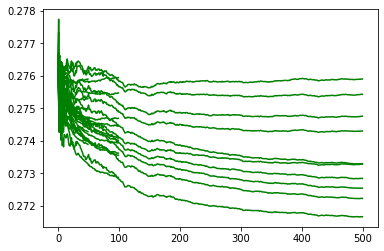

In [60]:
s = sparse_val.toarray()
lambda_s = [0.0001, 0.001, 0.01, 0.1, 1 , 10, 20, 30, 50, 100]
epochs = [10, 50, 100, 500]
for lam in lambda_s:
    for epoch in epochs:
        coef = perform_sgd(sparse[: 5000], train_label[: 5000], 0.01, lam, epoch, decrease = True, plot = True)
        error = compute_mis(coef, s, val_label)
        print("lambda: {} | epoch: {} | error rate: {}".format(lam, epoch, error))

In [0]:
# We can observe that the accuracy rate decreases as the size of batches 
# increase. The optimal value of lambda seems to be between 10 and 30.   
# We can narrow down the scope of optimal lambdas and number of iterations. 

lambda: 0.01 | epoch: 250 | error: 0.4554
lambda: 0.05 | epoch: 250 | error: 0.4554
lambda: 0.1 | epoch: 250 | error: 0.4554
lambda: 1 | epoch: 250 | error: 0.4553333333333333
lambda: 10 | epoch: 250 | error: 0.4554
lambda: 15 | epoch: 250 | error: 0.4554
lambda: 20 | epoch: 250 | error: 0.4554
lambda: 25 | epoch: 250 | error: 0.4554
lambda: 30 | epoch: 250 | error: 0.4554
lambda: 0.01 | epoch: 500 | error: 0.45653333333333335
lambda: 0.05 | epoch: 500 | error: 0.45626666666666665
lambda: 0.1 | epoch: 500 | error: 0.4557333333333333
lambda: 1 | epoch: 500 | error: 0.45953333333333335
lambda: 10 | epoch: 500 | error: 0.4554
lambda: 15 | epoch: 500 | error: 0.4554
lambda: 20 | epoch: 500 | error: 0.4554
lambda: 25 | epoch: 500 | error: 0.4554
lambda: 30 | epoch: 500 | error: 0.4554
lambda: 0.01 | epoch: 750 | error: 0.47673333333333334
lambda: 0.05 | epoch: 750 | error: 0.46166666666666667
lambda: 0.1 | epoch: 750 | error: 0.4554
lambda: 1 | epoch: 750 | error: 0.45453333333333334
lambda

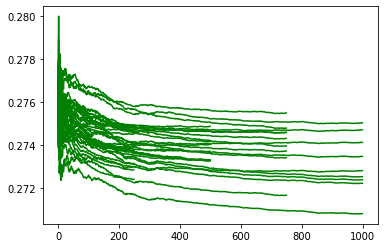

In [65]:
lambda_s = [0.01, 0.05, 0.1, 1, 10, 15, 20, 25, 30]
epochs = [250, 500, 750, 1000]
error_rate = []
lambda_ = []
epoch_ = []
for epoch in epochs:
    for lam in lambda_s:
        coef = perform_sgd(sparse[:5000], train_label[:5000], 0.01, lam, epoch, decrease = True)
        error = compute_mis(coef, s, val_label)
        print("lambda: {} | epoch: {} | error: {}".format(lam, epoch, error))
        error_rate.append(error)

Text(0.5, 0, 'lambdas')

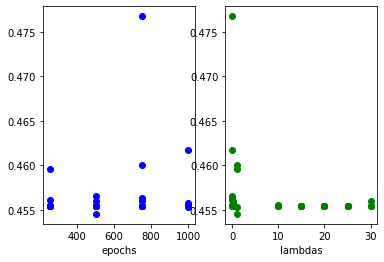

In [67]:
plt.subplot(121)
plt.plot(epochs * len(lambda_s) , error_rate,'bo')
plt.xlabel("epochs")
plt.subplot(122)
plt.plot(lambda_s * len(epochs), error_rate,'go')
plt.xlabel("lambdas")

In [0]:
# The results show that the optimal lambda value and the number of epochs are 
# about 1 and 400 respectively(based on the sample of training data we used).
# We can use these figures to model the test data   
# and compare the results with the Logistic Regression function

In [0]:
st = sparse_test.toarray()
coef = perform_sgd(sparse[: 5000], train_label[: 5000], 0.01, 1, 750, decrease = True, plot = False)
error = compute_mis(coef, st, test_label)

In [69]:
print("test error: ", error)

test error:  0.45053333333333334


In [0]:
# Although the speed of computation is much faster for the stoichastic 
# gradient descent method, the logistic regression function in the previous 
# item was slightly more accurate. When we implemented stoichastic gradient 
# descent, the lowest error rate we could achieve on the test set was
# only 0.4497

In [0]:
# Part 3: Scores versus text 

In [0]:
# Function that compiles the scores for other criteria 

In [0]:
def compile_scores(data):
    lst = []
    for i in range(len(data)):
        lst.append([data.iloc[i]['appearance'], data.iloc[i]['aroma'],\
        data.iloc[i]['palate'], data.iloc[i]['style'], data.iloc[i]['taste']])
    return np.array(lst)

In [0]:
train_scores = compile_scores(train_data)

In [0]:
test_scores = compile_scores(test_data)
val_scores = compile_scores(val_data)

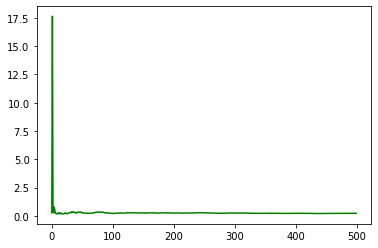

In [76]:
coef = perform_sgd(val_scores[:5000], val_label[:5000], 0.01, 10, 500, decrease = True, plot = True)

In [0]:
# The results show that the loss function converges much quicker than the model
# using only overall ratings 

In [78]:
lambda_s = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
epochs = [50, 100, 500]
error = []
epoch_ = []
lambda_ = []
for epoch in epochs:
    for lam in lambda_s:
        coef = perform_sgd(train_scores[:5000], train_label[:5000], 0.01, lam, \
                           epoch, decrease = True, plot = False)
        e = compute_mis(coef, val_scores, val_label)
        print("lambda: {} | epoch: {} | error:  {}".format(lam, epoch, e))
        epoch_.append(epoch)
        lambda_.append(lam)
        error.append(e)

lambda: 0.001 | epoch: 50 | error:  0.4554
lambda: 0.01 | epoch: 50 | error:  0.4554
lambda: 0.1 | epoch: 50 | error:  0.4554
lambda: 1 | epoch: 50 | error:  0.4554
lambda: 10 | epoch: 50 | error:  0.4554
lambda: 100 | epoch: 50 | error:  0.4554
lambda: 1000 | epoch: 50 | error:  0.4612
lambda: 0.001 | epoch: 100 | error:  0.4554
lambda: 0.01 | epoch: 100 | error:  0.4554
lambda: 0.1 | epoch: 100 | error:  0.4554
lambda: 1 | epoch: 100 | error:  0.4554
lambda: 10 | epoch: 100 | error:  0.4554
lambda: 100 | epoch: 100 | error:  0.4554
lambda: 1000 | epoch: 100 | error:  0.4554
lambda: 0.001 | epoch: 500 | error:  0.4996
lambda: 0.01 | epoch: 500 | error:  0.45213333333333333
lambda: 0.1 | epoch: 500 | error:  0.4554
lambda: 1 | epoch: 500 | error:  0.4554
lambda: 10 | epoch: 500 | error:  0.46026666666666666
lambda: 100 | epoch: 500 | error:  0.4554
lambda: 1000 | epoch: 500 | error:  0.4554


Text(0.5, 0, 'lambda')

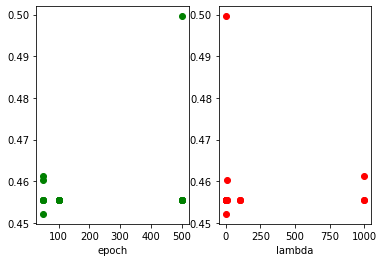

In [79]:
plt.subplot(121)
plt.plot(epochs * len(lambda_s), error,'go')
plt.xlabel("epoch")
plt.subplot(122)
plt.plot(lambda_s * len(epochs), error,'ro')
plt.xlabel("lambda")

In [0]:
# Computing the prediction error on the testing set 

test error:  0.4534


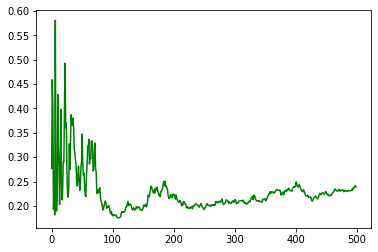

In [80]:
coef2 = perform_sgd(train_scores[:5000], train_label[:5000], 0.01, 0.01, 500, decrease = True, plot = True)
error2 = compute_mis(coef2, test_scores, test_label)
print("test error: ", error2)

In [0]:
# In general, the previous model to which we fed overall reviews is more 
# effective because the score models have generated higher error rates. The 
# results are acceptable considering the fact that texts provide more information 
# about ratings than mere numbers. 